In [1]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-08 15:27:59--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0.002s  

2024-07-08 15:27:59 (1.03 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

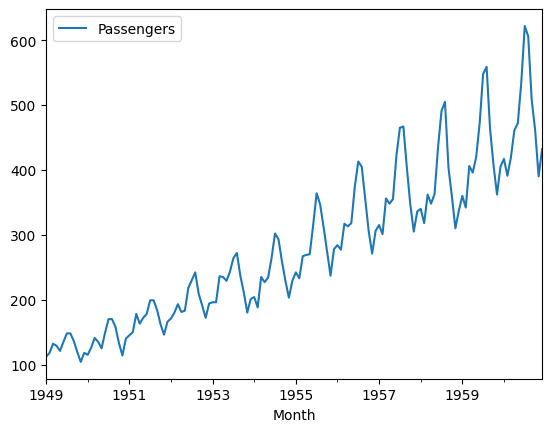

In [6]:
df.plot()

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [13]:
alpha = 0.2

In [8]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [10]:
df.index.freq = 'MS'

In [11]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [14]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [15]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [16]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

<Axes: xlabel='Month'>

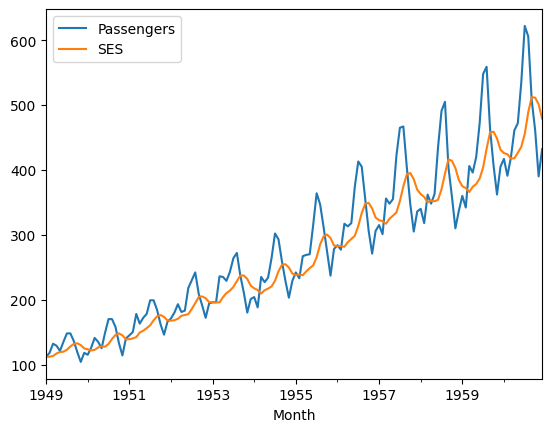

In [18]:
df.plot()

In [19]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [20]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [21]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<Axes: xlabel='Month'>

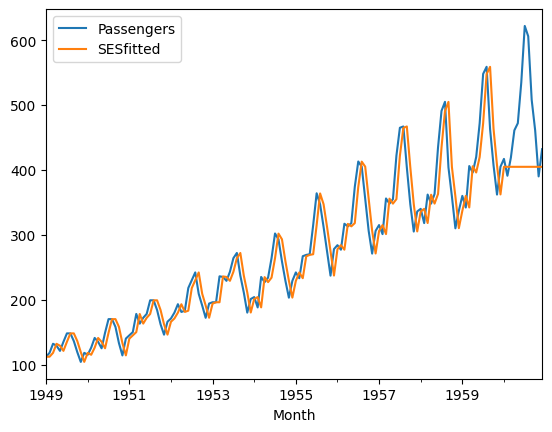

In [23]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot()

In [24]:
from statsmodels.tsa.holtwinters import Holt

In [25]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [26]:
res_h = holt.fit()

In [27]:
df['Holt'] = res_h.fittedvalues

<Axes: xlabel='Month'>

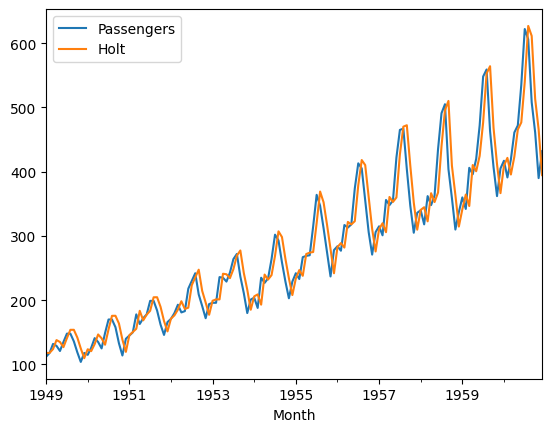

In [28]:
df[['Passengers', 'Holt']].plot()

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [31]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [32]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<Axes: xlabel='Month'>

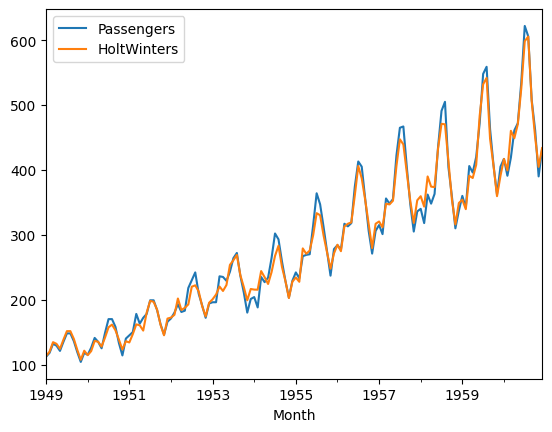

In [33]:
df[['Passengers', 'HoltWinters']].plot()

In [34]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))
def mae(y, t):
  return np.mean(np.abs(y - t))

In [35]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.852991011783207
Test RMSE: 15.543111991500705


In [36]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.892104709565825
Test MAE: 10.438248925951669


<Axes: xlabel='Month'>

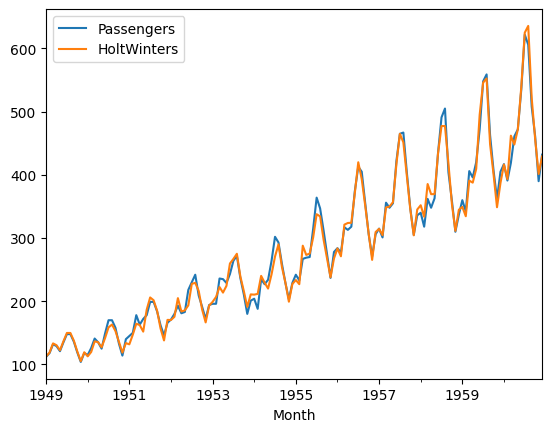

In [37]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot()

In [38]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838980438
Test RMSE: 16.535212281569763


In [39]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.552052652436032
Test MAE: 10.683341281007742


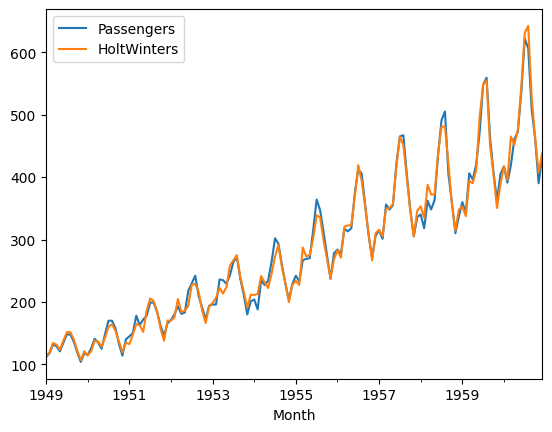

In [40]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot()

In [41]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.887178133823737
Test RMSE: 19.102054601493283


In [42]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.408707684654389
Test MAE: 13.450466754546861
